In [3]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
)
from lightgbm import LGBMClassifier

# ==========================================================
# PATHS (single source of truth)
# ==========================================================
DATA_PATH = "D:/EY_Internship/p2p07_synthetic_10k_imbalance_with_pending.csv"

FEATURE_COLUMNS_PATH = "D:/EY_Internship/feature_columns.joblib"
INVOICE_BINS_PATH = "D:/EY_Internship/invoice_amt_bins.joblib"



# Pending I/O
PENDING_INPUT_PATH = "D:/EY_Internship/pending_for_review_100_rows_clean.csv"
PENDING_OUTPUT_PATH = "pending_with_predictions_ocsvm.csv"


In [2]:
def preprocess_p2p(
    df: pd.DataFrame,
    *,
    feature_columns: list[str] | None = None,
    invoice_amt_bins: np.ndarray | None = None,
    is_training: bool = False
):
    df = df.copy()

    df["Invoice_Amount"] = pd.to_numeric(df.get("Invoice_Amount"), errors="coerce")
    df = df.dropna(subset=["Invoice_Amount"])

    if is_training:
        _, bins = pd.qcut(df["Invoice_Amount"], q=5, retbins=True, duplicates="drop")
        invoice_amt_bins = bins

    if invoice_amt_bins is not None:
        labels = ["Very_Low", "Low", "Medium", "High", "Very_High"]
        effective_k = len(invoice_amt_bins) - 1
        effective_labels = labels[:effective_k]

        df["Invoice_Amt_Bucket"] = pd.cut(
            df["Invoice_Amount"],
            bins=invoice_amt_bins,
            labels=effective_labels,
            include_lowest=True
        )
        df["Invoice_Amt_Bucket_Code"] = df["Invoice_Amt_Bucket"].cat.codes.replace(-1, np.nan)
    else:
        df["Invoice_Amt_Bucket"] = pd.qcut(
            df["Invoice_Amount"], q=5,
            labels=["Very_Low", "Low", "Medium", "High", "Very_High"],
            duplicates="drop"
        )
        df["Invoice_Amt_Bucket_Code"] = pd.qcut(
            df["Invoice_Amount"], q=5, labels=False, duplicates="drop"
        )

    df = pd.get_dummies(df, columns=["Invoice_Amt_Bucket"], drop_first=True)

    df["Invoice_Date"] = pd.to_datetime(df.get("Invoice_Date"), errors="coerce", dayfirst=True)
    df["Posting_Date"] = pd.to_datetime(df.get("Posting_Date"), errors="coerce", dayfirst=True)

    dup_lookup = df[["Doc_id", "Invoice_Amount", "Invoice_Date"]].rename(
        columns={
            "Doc_id": "Duplicate_doc_id",
            "Invoice_Amount": "Dup_Invoice_Amount",
            "Invoice_Date": "Dup_Invoice_Date",
        }
    )
    df = df.merge(dup_lookup, on="Duplicate_doc_id", how="left")

    df["Invoice_Amt_Diff"] = (df["Invoice_Amount"] - df["Dup_Invoice_Amount"]).abs()
    df["Invoice_Date_Diff_Days"] = (df["Invoice_Date"] - df["Dup_Invoice_Date"]).dt.days.abs()
    df["Invoice_Amt_Diff_Ratio"] = df["Invoice_Amt_Diff"] / (df["Invoice_Amount"] + 1)

    def date_diff_bucket(x):
        if pd.isna(x):
            return np.nan
        if x == 0:
            return "Same_Day"
        elif x <= 2:
            return "1_2_Days"
        else:
            return "Above_2_Days"

    df["Invoice_Date_Diff_Bucket"] = df["Invoice_Date_Diff_Days"].apply(date_diff_bucket)

    DROP_COLS = [
        "Doc_id", "Invoice_ID", "Vendor_Code", "Vendor_Name",
        "Vendor_GSTIN", "Invoice_Number", "Currency", "comments",
        "Duplicate_doc_id", "Exception_Type",
        "Invoice_Amt_Bucket", "Invoice_Amount", "Dup_Invoice_Amount",
    ]
    df_model = df.drop(columns=DROP_COLS, errors="ignore")

    categorical_cols = [
        "Invoice_Type",
        "Invoice_Source",
        "Business_Unit",
        "Exception_Number",
        "Invoice_Date_Diff_Bucket",
    ]
    df_model = pd.get_dummies(df_model, columns=categorical_cols, drop_first=True)

    if is_training:
        feature_columns = df_model.columns.tolist()
    else:
        if feature_columns is None:
            raise ValueError("feature_columns is required for inference.")
        for c in feature_columns:
            if c not in df_model.columns:
                df_model[c] = 0
        extra = [c for c in df_model.columns if c not in feature_columns]
        if extra:
            df_model = df_model.drop(columns=extra)
        df_model = df_model[feature_columns]

    return df_model, feature_columns, invoice_amt_bins

In [4]:
def topk_metrics(y_true: np.ndarray, y_proba: np.ndarray, top_frac: float = 0.10):
    """
    Precision@TopK and Recall@TopK where K = top_frac * N by predicted risk.
    """
    y_true = np.asarray(y_true).astype(int)
    y_proba = np.asarray(y_proba)

    n = len(y_true)
    k = max(1, int(np.ceil(top_frac * n)))

    idx = np.argsort(-y_proba)[:k]  # top K highest prob
    y_top = y_true[idx]

    tp_top = y_top.sum()
    total_pos = y_true.sum()

    precision_at_k = tp_top / k
    recall_at_k = tp_top / total_pos if total_pos > 0 else 0.0
    return precision_at_k, recall_at_k, k


In [5]:
# ==========================================================
# Load raw data + schema
# ==========================================================
df = pd.read_csv(DATA_PATH)
feature_columns = joblib.load(FEATURE_COLUMNS_PATH)

# ==========================================================
# Learn invoice bins from TRUE/FALSE only
# ==========================================================
df_tf = df[df["user_action_status"].isin(["TRUE", "FALSE"])].copy()
_, _, invoice_amt_bins = preprocess_p2p(df_tf, is_training=True)
joblib.dump(invoice_amt_bins, INVOICE_BINS_PATH)


['D:/EY_Internship/invoice_amt_bins.joblib']

In [6]:
# ==========================================================
# Preprocess full dataset aligned to schema
# ==========================================================
df_model, _, _ = preprocess_p2p(
    df,
    feature_columns=feature_columns,
    invoice_amt_bins=invoice_amt_bins,
    is_training=False
)


In [7]:
# ==========================================================
# Build training set
# ==========================================================
mask_tf = df["user_action_status"].isin(["TRUE", "FALSE"])
df_train = df_model.loc[mask_tf].copy()

df_train["y"] = df.loc[df_train.index, "user_action_status"].map({
    "FALSE": 0,
    "TRUE": 1
})

X = df_train[feature_columns]
y = df_train["y"].astype(int)

In [8]:
# ==========================================================
# Train / test split
# ==========================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [9]:
pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print("pos_weight:", pos_weight)


pos_weight: 9.0


In [11]:
import lightgbm as lgb

lgbm = lgb.LGBMClassifier(
    n_estimators=800,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    scale_pos_weight=pos_weight
)

lgbm.fit(X_train, y_train)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 640, number of negative: 5760
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 325
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.100000 -> initscore=-2.197225
[LightGBM] [Info] Start training from score -2.197225


LGBMClassifier(colsample_bytree=0.9, learning_rate=0.05, n_estimators=800,
               random_state=42, scale_pos_weight=np.float64(9.0),
               subsample=0.9)

In [12]:
# ==========================================================
# Evaluation
# ==========================================================
y_pred = lgbm.predict(X_test)
y_proba = lgbm.predict_proba(X_test)[:, 1]

print("\n=== LightGBM ===")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))

roc_auc = roc_auc_score(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)

p_at_10, r_at_10, k = topk_metrics(y_test.values, y_proba, top_frac=0.10)

print("ROC-AUC:", roc_auc)
print("PR-AUC:", pr_auc)
print(f"Precision@Top10% (K={k}):", p_at_10)
print(f"Recall@Top10% (K={k}):", r_at_10)



=== LightGBM ===
Confusion Matrix:
 [[1219  221]
 [  40  120]]
              precision    recall  f1-score   support

           0     0.9682    0.8465    0.9033      1440
           1     0.3519    0.7500    0.4790       160

    accuracy                         0.8369      1600
   macro avg     0.6601    0.7983    0.6912      1600
weighted avg     0.9066    0.8369    0.8609      1600

ROC-AUC: 0.8725347222222223
PR-AUC: 0.6647429404971278
Precision@Top10% (K=160): 0.54375
Recall@Top10% (K=160): 0.54375


In [13]:
# Save model

LGBM_MODEL_PATH = "lgbm_model.joblib"
LGBM_FEATURE_IMPORTANCE_PATH = "lgbm_feature_importances_gain.csv"
joblib.dump(lgbm, LGBM_MODEL_PATH)
print("\nSaved model:", LGBM_MODEL_PATH)


Saved model: lgbm_model.joblib


Saved feature importances: lgbm_feature_importances_gain.csv


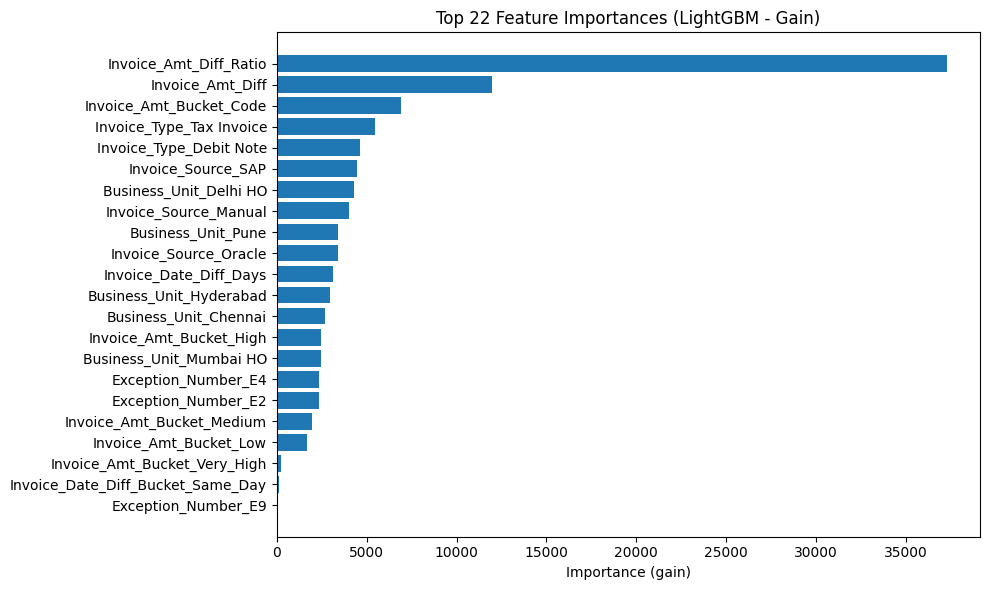

In [14]:

# ==========================================================
# Feature importance (LightGBM - Gain)
# ==========================================================
imp = pd.DataFrame({
    "feature": feature_columns,
    "importance_gain": lgbm.booster_.feature_importance(importance_type="gain"),
    "importance_split": lgbm.booster_.feature_importance(importance_type="split"),
}).sort_values("importance_gain", ascending=False)

imp.to_csv(LGBM_FEATURE_IMPORTANCE_PATH, index=False)
print("Saved feature importances:", LGBM_FEATURE_IMPORTANCE_PATH)

topk_plot = 22
imp_plot = imp.head(topk_plot)

plt.figure(figsize=(10, 6))
plt.barh(imp_plot["feature"][::-1], imp_plot["importance_gain"][::-1])
plt.xlabel("Importance (gain)")
plt.title(f"Top {topk_plot} Feature Importances (LightGBM - Gain)")
plt.tight_layout()
plt.show()